In [ ]:
pip install fiftyone

In [2]:
import os
import fiftyone as fo
import fiftyone.zoo as foz
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import cv2

from torch.utils.data import Dataset
import numpy as np
from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms.functional as TF

import torch
from sklearn.metrics import f1_score

import psutil
import gc
import torch.optim as optim

In [3]:
classes = ["Cat", "Dog", "Bird"]

trainDataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["segmentations"],
    num_workers = 4,
    max_samples = 500,
    classes = classes
)

validationDataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=["segmentations"],
    num_workers = 4,
    max_samples = 100,
    classes = classes
)

if not os.path.exists("saved_images"):
    os.mkdir("saved_images")

 100% |██████|    4.8Gb/4.8Gb [17.8s elapsed, 0s remaining, 276.5Mb/s]      
 100% |███████████████████| 200/200 [11.2s elapsed, 0s remaining, 24.4 files/s]      
Dataset info written to 'C:\Users\deniz\fiftyone\open-images-v6\info.json'
Loading 'open-images-v6' split 'train'
 100% |█████████████████| 200/200 [20.9s elapsed, 0s remaining, 12.8 samples/s]      
Dataset 'open-images-v6-train-200' created
 100% |█████████████████████| 25/25 [3.4s elapsed, 0s remaining, 7.3 files/s]      
Dataset info written to 'C:\Users\deniz\fiftyone\open-images-v6\info.json'
Loading 'open-images-v6' split 'validation'
 100% |███████████████████| 25/25 [2.1s elapsed, 0s remaining, 12.1 samples/s]      
Dataset 'open-images-v6-validation-25' created


In [4]:
sample = trainDataset.first()
print(sample) # this is how a downloaded fiftyone sample looks like, the important part is mask

<Sample: {
    'id': '6627c24e08118e2c54e23c97',
    'media_type': 'image',
    'filepath': 'C:\\Users\\deniz\\fiftyone\\open-images-v6\\train\\data\\0000b9fcba019d36.jpg',
    'tags': ['train'],
    'metadata': None,
    'ground_truth': <Detections: {
        'detections': [
            <Detection: {
                'id': '6627c24e08118e2c54e23c96',
                'attributes': {},
                'tags': [],
                'label': 'Dog',
                'bounding_box': [0.165, 0.268333, 0.73875, 0.73],
                'mask': array([[False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       ...,
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False]]),
                '

# Helper methods

In [5]:
def get_image_size(file_path):
    with Image.open(file_path) as img:
        width, height = img.size
        return width, height

# We will have to return a modified image
def get_image_mask_from_bounding_box(file_path, mask, bounding_box):
    width, height = get_image_size(file_path)
    image_shape = (height, width)

    # Create an empty mask with the same shape as the image
    image_mask = np.zeros(image_shape, dtype=bool) # initializes with 0, dtype=bool specifies that datatype is boolean

    # Calculate the bounding box coordinates in pixel values
    x1, y1, w, h = bounding_box
    x1_pixel = int(x1 * image_shape[1])
    y1_pixel = int(y1 * image_shape[0])
    w_pixel = int(w * image_shape[1])
    h_pixel = int(h * image_shape[0])

    # Resize the mask to match the bounding box dimensions
    resized_mask = np.zeros((h_pixel, w_pixel), dtype=bool)
    mask_resized = cv2.resize(mask.astype(np.uint8), (w_pixel, h_pixel)) # np.uint8 - integer values ranging from 0 to 255
    # applies boolean values to the specific region
    resized_mask[:mask_resized.shape[0], :mask_resized.shape[1]] = mask_resized.astype(bool) # turns it back into bool values

    # Place the resized mask within the bounding box region of the empty mask
    image_mask[y1_pixel:y1_pixel+h_pixel, x1_pixel:x1_pixel+w_pixel] = resized_mask

    return image_mask

# basically, we take the og image and mask
# we initialize new mask to contain 0
# since out objects are inside bounding boxes, we concern ourselves only with changing the internals of those
# we take coordinates of bounding box and create mini mask for those coordinates
# then we resize the og mask to mini coordinates

# Dataset
This is done because fiftyone dataset provides unnecessary information for our calculations - we only need image and mask

In [6]:
class CustomDataset(Dataset):
    def __init__(self, dataset, classes, transform=None):
        self.transform = transform
        self.dataset = dataset
        self.target_clases = classes
        self.images = []  # Initialize list to store images
        self.validDetections = []  # Initialize list to store masks

        # Populate images, masks, and assigned classes
        for sample in self.dataset:

            # Add image to the image array
            image = np.array(Image.open(sample.filepath).convert("RGB"))
            self.images.append(image)

            # if you look at output of dataset, you will see that there is nested json 
            # ground_truth{ detections{ detection containing mask, label, bounding box}}
            # there are multiple detections because we load data in batches of 16
            detections = sample["ground_truth"]["detections"]  
            valid_detections = []

            # We iterate trough the detections and find which belong to our defined classes
            for detection in detections:
              label = detection["label"]
              if label in self.target_clases:
                # We save the label and the mask of the object that matches the class that we are looking for
                valid_detection = {}
                valid_detection["class"] = label
                # We find the mask of the valid detection
                mask = detection.mask
                bounding_box = detection.bounding_box

                image_mask = get_image_mask_from_bounding_box(sample.filepath, mask, bounding_box)
                # Cast it into a different type for UNet architecture
                valid_detection["mask"] = image_mask.astype(np.float32)

                valid_detections.append(valid_detection)
            self.validDetections.append(valid_detections)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, i):

        detections = self.validDetections[i]

        # Initialize final mask with the first mask
        final_mask = detections[0]["mask"]

        # Iterate through the rest of the masks and combine them with the final mask
        for detection in detections[1:]:
            final_mask += detection["mask"]

        final_mask = np.clip(final_mask, 0, 1) # ensures all values in the array are in the range [0, 1]

        if self.transform:
            transformed = self.transform(image = self.images[i], mask = final_mask) # transformation is appliead to both separately
            image = transformed["image"]
            mask = transformed["mask"]
            return image, mask

        return self.images[i], final_mask

# Transformations

In [7]:
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 240

train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

# Testing the custom dataset

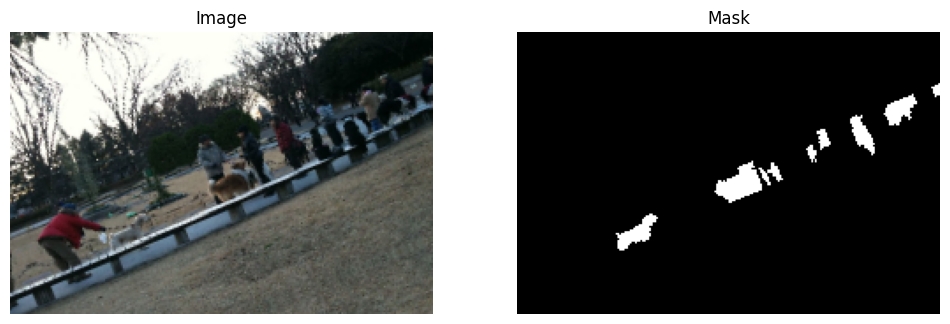

In [8]:
customDataset = CustomDataset(trainDataset, classes, train_transform)

def show_image_with_mask(image, mask):
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the image in the first subplot
    image = image.permute(1, 2, 0).numpy()
    axes[0].imshow(image)
    axes[0].set_title('Image')
    axes[0].axis('off')

    # Display the mask in the second subplot
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask')
    axes[1].axis('off')

    plt.show()

image, mask = customDataset[4]
show_image_with_mask(image, mask)
# print(image.shape)
# print(mask.shape) # the same as image.shape except theres no class because its black and white, so instead of rgb 3 theres nothing

# Defining the UNET architecture
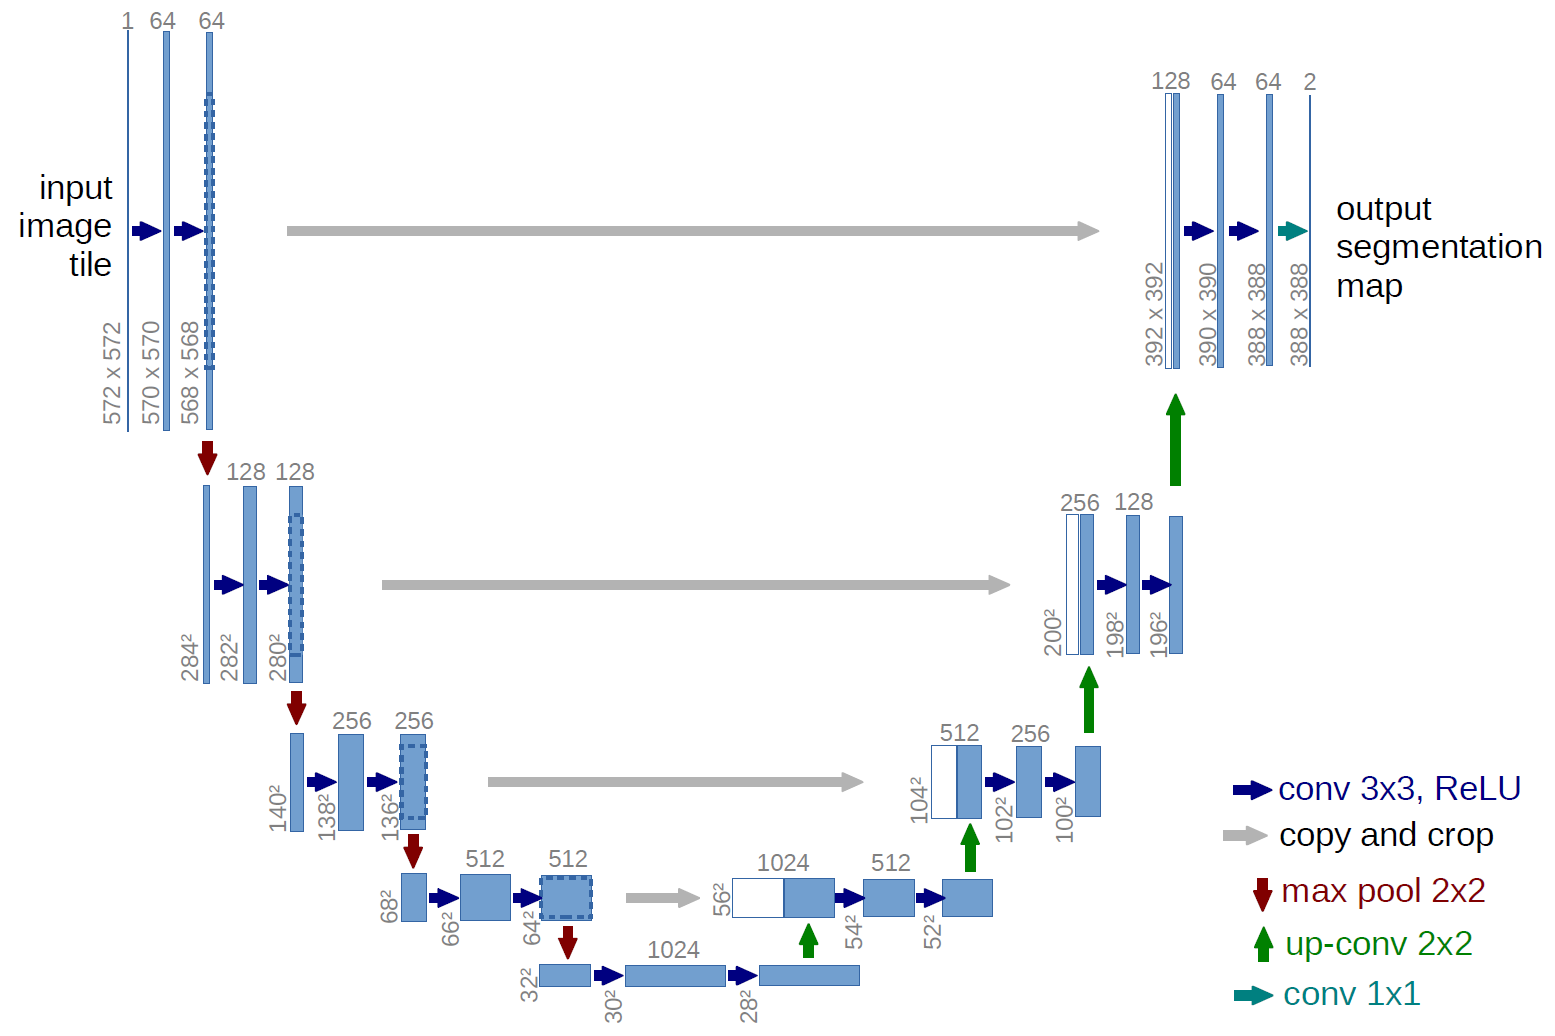


In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features=[64, 128, 256, 512],):
        super(UNET, self).__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottom_middle_layer = DoubleConv(features[-1], features[-1]*2) # features[-1] = 512
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottom_middle_layer(x)
        skip_connections = skip_connections[::-1] # ::-1 is reversed

        for i in range(0, len(self.ups), 2):
            x = self.ups[i](x)
            skip_connection = skip_connections[i//2]

            if x.shape != skip_connection.shape: # this can happen if input ch is not dividable by 2
                x = TF.resize(x, size=skip_connection.shape[2:])  # take out h and w, so were skiping batch size and nr of channels

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[i+1](concat_skip)

        return self.final_conv(x)

# Defining utilities for the training loop


In [18]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def get_loaders(
    batch_size, train_transform, val_transform, num_workers=4):
    train_ds = CustomDataset(trainDataset, classes, train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True,
    )

    val_ds = CustomDataset(validationDataset, classes, val_transform)

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
    )

    return train_loader, val_loader

def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float() # less than 0.5 get turned to 0
        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

# Statistics

In [19]:
def dice_coefficient(preds, true_values):
    # calculates the intersection between the predicted masks and the ground truth masks by multiplication
    # (so if both are 1 then 1, if one is false then 0), so only counts when both have it
    intersection = torch.sum(preds * true_values) # where both are correct
    union = torch.sum(preds) + torch.sum(true_values) # all values combining predicted and truth
    dice = (2. * intersection + 1e-6) / (union + 1e-6) # small epsilon to avoid division by 0
    return dice

def calculate_statistics(loader, model, device="cuda"):
    num_correct = 0
    num_pixels = 0
    dice_total = 0
    all_predictions = []
    all_true_values= []
    model.eval()

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).unsqueeze(1)
            
            # sigmoid because each pixel is classified as either object or background (binary segmentation), return value between 0 and 1
            predictions = torch.sigmoid(model(images)) 
            predictions = (predictions > 0.5).float() # less than 0.5 get turned to 0, otherwise 1

            num_correct += (predictions == masks).sum().item() # sum of all correct pixels between predicted mask and actual
            num_pixels += torch.numel(predictions) # returns the total number of elements in the input tensor

            dice_total += dice_coefficient(predictions, masks).item()
            all_predictions.extend(predictions.cpu().numpy().flatten())
            all_true_values.extend(masks.cpu().numpy().flatten())

    accuracy = num_correct / num_pixels
    dice = dice_total / len(loader)
    # Focuses on overall performance across all classes
    micro_f1 = f1_score(all_true_values, all_predictions, average='micro') # Calculate sum of TP, FP, FN and then smth with F1
    # Suitable for balanced datasets or when you want to evaluate class-specific performance
    macro_f1 = f1_score(all_true_values, all_predictions, average='macro') # gets f1 of each class and then divides by class nr

    print(f"-------------------------------------\nSTATISTICS")
    print(
        f"Accuracy: {num_correct}/{num_pixels} ({accuracy:.5f})"
    )
    print(f"Dice: {dice:.4f}")
    print(f"Micro-F1: {micro_f1:.4f}")
    print(f"Macro-F1: {macro_f1:.4f}")
    print("-------------------------------------")

    model.train()

In [13]:
def free_memory():
    gc.collect()
    mem = psutil.virtual_memory()
    print(f"Memory used: {mem.used / 1e9} GB")
    print(f"Memory available: {mem.available / 1e9} GB")

free_memory()

Memory used: 13.598060544 GB
Memory available: 3.443183616 GB


# Training loop

In [20]:
train_loader, val_loader = get_loaders(16, train_transform, val_transforms, 4)

N_train = len(train_loader)
N_test = len(val_loader)


def TrainModel(NUM_EPOCHS, LEARNING_RATE, model):
    loss_fn = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss with Logits (i think it does sigmoid internally)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        loop = tqdm(train_loader) # shows visual progress bar of the training process in real-time
    
        for batch_i, (data, targets) in enumerate(loop):
            data = data.to(device=DEVICE)
            targets = targets.float().unsqueeze(1).to(device=DEVICE) # true binary labels (0s and 1s)

            # forward
            with torch.cuda.amp.autocast():
                predictions = model(data) # raw output scores from the network (logits). These are the values before applying sigmoid
                train_loss = loss_fn(predictions, targets) 

            # backward
            optimizer.zero_grad()
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # update tqdm loop
            loop.set_postfix(loss=train_loss.item())

        loop2 = tqdm(val_loader)
        for batch_i, (data, targets) in enumerate(loop2):
            data = data.to(device=DEVICE)
            targets = targets.float().unsqueeze(1).to(device=DEVICE)

            # forward
            with torch.cuda.amp.autocast():
                predictions = model(data)
                test_loss = loss_fn(predictions, targets)

            # update tqdm loop
            loop.set_postfix(loss=test_loss.item())
      

        print('Epoch: {} | Train Loss: {:.6f} | Test Loss: {:.6f}'.format(
            epoch,
            train_loss / N_train,
            test_loss / N_test,
            ))
        
        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # print statistics
        calculate_statistics(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(val_loader, model, folder="saved_images/", device=DEVICE)

In [21]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNET(in_channels=3, out_channels=1).to(DEVICE)

TrainModel(20, 1e-3, model)
TrainModel(10, 1e-4, model)
TrainModel(5, 1e-5, model)

  0%|          | 0/13 [00:00<?, ?it/s]


PicklingError: Can't pickle <class 'mongoengine.base.metaclasses.samples.6627c23308118e2c54e23c95'>: attribute lookup samples.6627c23308118e2c54e23c95 on mongoengine.base.metaclasses failed

# UI

In [21]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://t39az1lh0eq-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [ ]:
from flask import Flask, render_template, request
import torchvision.transforms as transforms
import io
import base64

app = Flask(__name__, template_folder='./')

@app.route('/', methods=['GET', 'POST'])
def index():
    original_image_base64 = None
    mask_base64 = None

    if request.method == 'POST':
        file = request.files['file']
        original_image = np.array(Image.open(file).convert("RGB"))
        transformed_image = val_transforms(image=original_image)["image"]

        # Forward pass through the model to get predicted mask
        predicted_mask = model(torch.unsqueeze(transformed_image, 0).to(DEVICE))
        predicted_mask = torch.sigmoid(predicted_mask)
        predicted_mask = (predicted_mask > 0.5).float().cpu().squeeze().numpy()

        # Convert the model output (mask) to a PIL image
        mask_pil = transforms.ToPILImage()(predicted_mask)

        # Encode the original image and mask image as base64 strings
        original_image_buffered = io.BytesIO()
        mask_buffered = io.BytesIO()

        Image.fromarray(original_image).save(original_image_buffered, format="PNG")
        mask_pil.save(mask_buffered, format="PNG")

        original_image_base64 = base64.b64encode(original_image_buffered.getvalue()).decode('utf-8')
        mask_base64 = base64.b64encode(mask_buffered.getvalue()).decode('utf-8')

    # Render the HTML template with the original image and mask image data
    return render_template('index.html', original_image=original_image_base64, mask=mask_base64)

if __name__ == "__main__":
  app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
